Starting Training...
Epoch 0: Loss = 3.86185
Epoch 500: Loss = 0.95607
Epoch 1000: Loss = 0.08104
Epoch 1500: Loss = 0.05480
Epoch 2000: Loss = 0.04252
Epoch 2500: Loss = 0.03748
Epoch 3000: Loss = 0.06022
Epoch 3500: Loss = 0.02844
Epoch 4000: Loss = 0.02101
Epoch 4500: Loss = 0.01813
Epoch 5000: Loss = 0.01701
Epoch 5500: Loss = 0.01631
Epoch 6000: Loss = 0.01574
Epoch 6500: Loss = 0.01581
Epoch 7000: Loss = 0.01620
Epoch 7500: Loss = 0.01539
Epoch 8000: Loss = 0.01469
Epoch 8500: Loss = 0.01401
Epoch 9000: Loss = 0.01348
Epoch 9500: Loss = 0.01283
Epoch 10000: Loss = 0.01234
Epoch 10500: Loss = 0.01192
Epoch 11000: Loss = 0.01145
Epoch 11500: Loss = 0.01120
Epoch 12000: Loss = 0.01045
Epoch 12500: Loss = 0.00975
Epoch 13000: Loss = 0.01103
Epoch 13500: Loss = 0.01066
Epoch 14000: Loss = 0.01045
Epoch 14500: Loss = 0.00811
Training Complete. Generating Predictions...


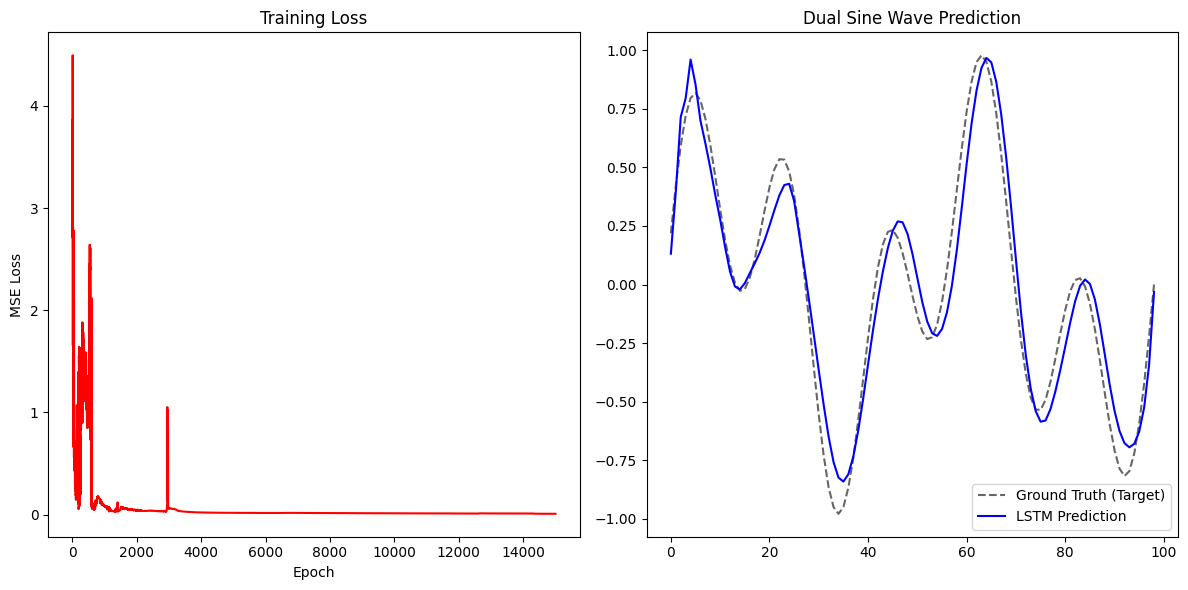

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from MewralLSTM import MewralOldLSTM

# 1. Data Generation: Sum of Two Sine Waves
def generate_dual_sine(seq_length):
    time_steps = np.linspace(0, 4 * np.pi, seq_length)
    # Wave 1: Low Frequency
    wave1 = np.sin(time_steps) 
    # Wave 2: High Frequency (2.5x faster)
    wave2 = np.sin(time_steps * 2.5)
    
    # Combine and normalize to range [-1, 1] for Tanh
    combined = (wave1 + wave2) / 2.0
    
    # Reshape for the LSTM: (Sequence_Length, Input_Size)
    return combined.reshape(-1, 1)

# 2. Setup Experiment
SEQ_LENGTH = 100
INPUT_SIZE = 1
HIDDEN_SIZE = 20  # Enough neurons to memorize the pattern
LAYERS = 1
OUTPUT_SIZE = 1

data = generate_dual_sine(SEQ_LENGTH)
# Targets are just the inputs shifted by 1 (Predict next step)
inputs = data[:-1]
targets = data[1:]

# Initialize your LSTM
lstm = MewralOldLSTM(INPUT_SIZE, HIDDEN_SIZE, LAYERS, OUTPUT_SIZE, initialization="xavier")

# 3. Training Loop
EPOCHS = 15000
learning_rate = 0.001
losses = []

print("Starting Training...")
for epoch in range(EPOCHS):
    
    # Run Backprop Through Time
    # (Make sure you fixed the 'return' line in BPTT!)
    loss = lstm.BPTT(inputs, targets, learning_rate)
    losses.append(loss)
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.5f}")
    
    if loss<0.09 :
        learning_rate = 0.0001
    if loss<0.005:
        break

# 4. Testing & Visualization
print("Training Complete. Generating Predictions...")

# Run a forward pass on the data to see what the network learned
predictions, _, _ = lstm.forward(inputs)

# Convert list of arrays to a single flat array for plotting
predictions = np.array(predictions).flatten()
targets_flat = targets.flatten()

# Plotting
plt.figure(figsize=(12, 6))

# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(losses, color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# Subplot 2: Predictions vs Ground Truth
plt.subplot(1, 2, 2)
plt.plot(targets_flat, label='Ground Truth (Target)', linestyle='dashed', color='black', alpha=0.6)
plt.plot(predictions, label='LSTM Prediction', color='blue')
plt.title("Dual Sine Wave Prediction")
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
# --- 1. Data Generator (Same as before) ---
def get_adding_problem_batch(batch_size, seq_len):
    inputs = []
    targets = []
    for _ in range(batch_size):
        values = np.random.uniform(-1, 1, (seq_len, 1))
        markers = np.zeros((seq_len, 1))
        idx1 = np.random.randint(0, int(seq_len / 2))
        idx2 = np.random.randint(int(seq_len / 2), seq_len - 1)
        markers[idx1] = 1.0
        markers[idx2] = 1.0
        
        inp = np.hstack((values, markers))
        true_sum = values[idx1] + values[idx2]
        
        # Target is only relevant at the last step
        targ = np.zeros((seq_len, 1))
        targ[-1] = true_sum 
        
        inputs.append(inp)
        targets.append(targ)
    return inputs, targets

# --- Setup ---
SEQ_LENGTH = 100
INPUT_SIZE = 2
HIDDEN_SIZE = 10 
LAYERS = 1
OUTPUT_SIZE = 1

# Initialize
lstm = MewralOldLSTM(INPUT_SIZE, HIDDEN_SIZE, LAYERS, OUTPUT_SIZE, initialization="xavier")

# --- The Strict "Consecutive Success" Loop ---
SUCCESS_THRESHOLD = 0.04  # The paper's criterion
GOAL_CONSECUTIVE = 2000   # The target streak
MAX_TRIALS = 100000       # Give up if not solved by then

consecutive_wins = 0
learning_rate = 0.05
history = []

print(f"Starting STREAK TEST.")
print(f"Goal: {GOAL_CONSECUTIVE} correct sequences in a row (Error < {SUCCESS_THRESHOLD})")

for trial in range(MAX_TRIALS):
    # 1. Generate 1 Random Example
    input_batch, target_batch = get_adding_problem_batch(1, SEQ_LENGTH)
    inputs = input_batch[0]
    targets = target_batch[0]
    real_target = targets[-1][0] # The actual sum number

    # 2. Check Prediction BEFORE Training (To test what it learned)
    # We run a forward pass to see if it gets it right based on past learning
    preds, _, _ = lstm.forward(inputs)
    prediction = preds[-1][0].item() # Extract scalar
    
    # 3. Calculate Absolute Error
    abs_error = abs(prediction - real_target)
    
    # 4. TRAIN (Backprop)
    # We train on this example regardless of whether we got it right/wrong
    # to keep improving.
    lstm.BPTT(inputs, targets, learning_rate)
    
    # 5. Update Streak Logic
    if abs_error < SUCCESS_THRESHOLD:
        consecutive_wins += 1
    else:
        if consecutive_wins > 100: # Only print if we lost a decent streak
            print(f"Streak Broken at {consecutive_wins}! (Error: {abs_error:.4f})")
        consecutive_wins = 0 # RESET COUNTER
        
    history.append(abs_error)

    # 6. Success Check
    if consecutive_wins >= GOAL_CONSECUTIVE:
        print(f"\n✅ PASSED! Reached {GOAL_CONSECUTIVE} consecutive successes.")
        print(f"Total Trials Needed: {trial}")
        print(f"Final Error: {abs_error:.5f}")
        break

    # Status Update
    if trial % 1000 == 0:
        avg_err = np.mean(history[-1000:])
        print(f"Trial {trial}: Current Streak = {consecutive_wins} | Avg Err (Last 1k) = {avg_err:.4f}")

# --- Plot Results ---
plt.plot(history)
plt.axhline(y=SUCCESS_THRESHOLD, color='r', linestyle='--', label='Success Threshold (0.04)')
plt.title("Absolute Error over Trials")
plt.xlabel("Trial Sequence")
plt.ylabel("Absolute Error")
plt.legend()
plt.show()

Starting STREAK TEST.
Goal: 2000 correct sequences in a row (Error < 0.04)
Trial 0: Current Streak = 0 | Avg Err (Last 1k) = 0.2541
Trial 1000: Current Streak = 0 | Avg Err (Last 1k) = 0.7330
Trial 2000: Current Streak = 0 | Avg Err (Last 1k) = 0.6693
Trial 3000: Current Streak = 0 | Avg Err (Last 1k) = 0.6649
Trial 4000: Current Streak = 0 | Avg Err (Last 1k) = 0.6606
Trial 5000: Current Streak = 0 | Avg Err (Last 1k) = 0.6601
Trial 6000: Current Streak = 0 | Avg Err (Last 1k) = 0.6556
Trial 7000: Current Streak = 0 | Avg Err (Last 1k) = 0.6937
Trial 8000: Current Streak = 0 | Avg Err (Last 1k) = 0.6640
Trial 9000: Current Streak = 0 | Avg Err (Last 1k) = 0.6774
Trial 10000: Current Streak = 0 | Avg Err (Last 1k) = 0.6695
Trial 11000: Current Streak = 0 | Avg Err (Last 1k) = 0.6474
Trial 12000: Current Streak = 0 | Avg Err (Last 1k) = 0.6871
Trial 13000: Current Streak = 0 | Avg Err (Last 1k) = 0.6532
Trial 14000: Current Streak = 0 | Avg Err (Last 1k) = 0.6798
Trial 15000: Current St

KeyboardInterrupt: 

Running Simple Sine Test...
Epoch 0: Loss = 19.26065
Epoch 100: Loss = 0.04822
Epoch 200: Loss = 0.23519
Epoch 300: Loss = 0.05637
Epoch 400: Loss = 0.03458
Epoch 500: Loss = 0.02317
Epoch 600: Loss = 0.02676
Epoch 700: Loss = 0.85635
Epoch 800: Loss = 0.02928
Epoch 900: Loss = 0.04442
Epoch 1000: Loss = 0.03125
Epoch 1100: Loss = 0.03850
Epoch 1200: Loss = 0.02348
Epoch 1300: Loss = 0.01821
Epoch 1400: Loss = 0.02464
Epoch 1500: Loss = 0.01853
Epoch 1600: Loss = 0.00524
Epoch 1700: Loss = 0.00305
Epoch 1800: Loss = 0.01168
Epoch 1900: Loss = 0.01008
Epoch 2000: Loss = 0.03004
Epoch 2100: Loss = 0.01864
Epoch 2200: Loss = 0.02192
Epoch 2300: Loss = 0.01769
Epoch 2400: Loss = 0.06765
Epoch 2500: Loss = 0.02488
Epoch 2600: Loss = 0.03735
Epoch 2700: Loss = 0.04130
Epoch 2800: Loss = 0.01935
Epoch 2900: Loss = 0.02967
Epoch 3000: Loss = 0.02555
Epoch 3100: Loss = 0.06421
Epoch 3200: Loss = 0.04062
Epoch 3300: Loss = 0.05111
Epoch 3400: Loss = 0.04736
Epoch 3500: Loss = 0.03517
Epoch 3600:

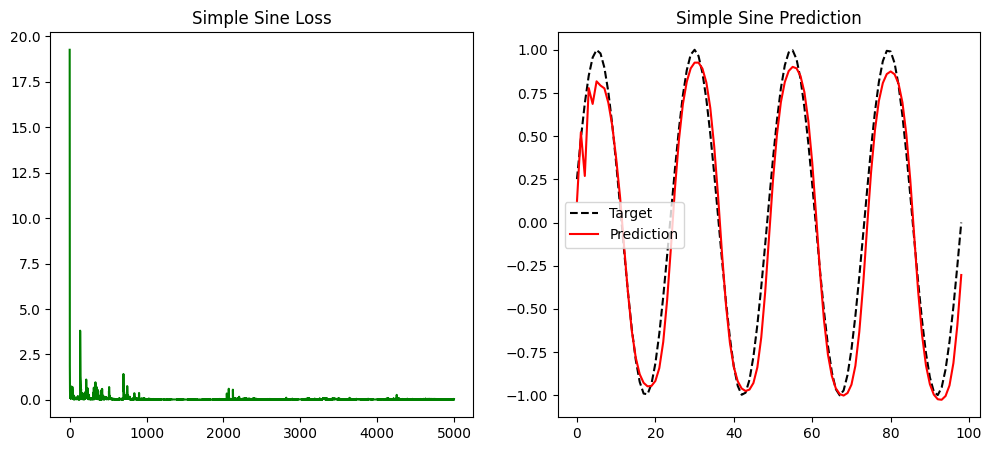

In [4]:
import numpy as np

# --- 1. Simple Sine Wave Data ---
def generate_simple_sine(seq_length):
    time_steps = np.linspace(0, 8 * np.pi, seq_length)
    data = np.sin(time_steps)
    return data.reshape(-1, 1)

# --- Setup ---
SEQ_LENGTH = 100
INPUT_SIZE = 1
HIDDEN_SIZE = 15  # Smaller hidden size is fine for simple patterns
LAYERS = 1
OUTPUT_SIZE = 1

data = generate_simple_sine(SEQ_LENGTH)
inputs = data[:-1]
targets = data[1:]

# --- Initialize ---
# Assuming your class is in a file named MewralLSTM or pasted above
lstm = MewralOldLSTM(INPUT_SIZE, HIDDEN_SIZE, LAYERS, OUTPUT_SIZE, initialization="xavier")

# --- Training ---
EPOCHS = 5000
# Note: Simple patterns converge faster, but let's give it room
learning_rate = 0.01
losses = []

print("Running Simple Sine Test...")
for epoch in range(EPOCHS):
    loss = lstm.BPTT(inputs, targets, learning_rate)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.5f}")

# --- Plotting ---
predictions, _, _ = lstm.forward(inputs)
predictions = np.array(predictions).flatten()
targets_flat = targets.flatten()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, color='green')
plt.title("Simple Sine Loss")
plt.subplot(1, 2, 2)
plt.plot(targets_flat, 'k--', label='Target')
plt.plot(predictions, 'r', label='Prediction')
plt.title("Simple Sine Prediction")
plt.legend()
plt.show()